<a href="https://colab.research.google.com/github/AbelRapha/DataProjects/blob/main/AIRBNB%20RIO/AirbnbRio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Airbnb Rio - Ferramento de Previsão de Preço de Imóvel para pessoas comuns
<br>

## *Contexto* 
<p> No Airbnb qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel alugando por alguma diária.</p>

<p>Você cria o seu perfil de host(pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.</p>

<p>Nesse anúncio, o host deve descrever as características do imóvel de forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o anúncio mais atrativo)</p>

<p>Existem dezenas de personalizações possíveis no anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigências de verificação de identidade do locador, etc.</p>

## *Nosso objetivo*

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

## *O que temos disponível, inspirações e créditos*

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download neste repositório (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

## *Expectativas Iniciais*

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

# __Importando as Bibliotecas e Bases de Dados__

In [93]:
import pandas as pd
import pathlib
from tqdm import tqdm
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

In [4]:
caminho_bases = pathlib.Path(r'/content/drive/MyDrive/Colab Notebooks/Projeto Airbnbn/dataset')

base_airbnb = pd.DataFrame()
with tqdm(total = 100) as barra_progresso:
  for arquivo in caminho_bases.iterdir():
      nome_mes = arquivo.name[:3]
      mes = meses[nome_mes]
      
      ano = arquivo.name[-8:]
      ano = int(ano.replace('.csv', ''))
      df = pd.read_csv(caminho_bases / arquivo.name, engine="python", error_bad_lines=False)
      df['ano'] = ano
      df['mes'] = mes
      base_airbnb = base_airbnb.append(df)
      barra_progresso.update(4)
    


100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


In [5]:
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ano,mes
0,17878,https://www.airbnb.com/rooms/17878,20190923212307,2019-09-24,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for Carni...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for Carni...,none,This is the best spot in Rio. Everything happe...,NaN,Excellent location. Close to all major public ...,The entire apartment is yours. It is a vacatio...,I will be available throughout your stay shoul...,Please leave the apartment in a clean fashion ...,NaN,NaN,https://a0.muscache.com/im/pictures/65320518/3...,NaN,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/67b13cea-8...,https://a0.muscache.com/im/pictures/67b13cea-8...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,30,4.0,4.0,30.0,30.0,4.0,30.0,2 weeks ago,t,22,47,77,312,2019-09-24,238,24.0,2010-07-15,2019-08-24,93.0,9.0,10.0,10.0,10.0,10.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.13,2019,9
1,25026,https://www.airbnb.com/rooms/25026,20190923212307,2019-09-24,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,"For any stay superior to 15 days, an additiona...",At night we recommend you to take taxis only. ...,"internet wi-fi, cable tv, air cond, ceiling fa...","Only at check in, we like to leave our guests ...",Smoking outside only. Family building so pleas...,NaN,NaN,https://a0.muscache.com/im/pictures/3003965/68...,NaN,102840,https://www.airbnb.com/users/show/102840,Viviane,2010-04-03,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Hi guys, We're a lovely team of 3 people:\r\n\...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/9e204f80-1...,https://a0.muscache.com/im/pictures/9e204f80-1...,Copacabana,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,60,7.0,7.0,60.0,60.0,7.0,60.0,5 weeks ago,t,11,41,71,114,2019-09-24,233,16.0,2010-06-07,2019-08-03,94.0,9.0,10.0,9.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,3,3.0,0.0,0.0,2.06,2019,9
2,31560,https://www.airbnb.com/rooms/31560,20190923212307,2019-09-24,NICE & COZY 1BDR - IPANEMA

## Visualizando as colunas do Data Frame
* Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
* Além disso, uma análise rápide irá nos permitir visuzlizar vária colunas que não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base.
* Tipos de colunas que vamos excluir:
  1. IDs, Links e informações não relevantes para o nosso modelo
  2. Informações duplicadas ou semelhantes(Ex. Data X Ano/Mês)
  3. Colunas preenchidas com texto livre. Pois, não rodaremos esse tipo de dado em nosso modelo.
  4. Colunas em que todos ou quase todos os valores são iguais
* Para isso, vaos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa





In [6]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep= ';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

Verificando se há algum valor na coluna Experience_offered 

In [7]:
print(base_airbnb[['experiences_offered']].value_counts())

experiences_offered
none                   902210
dtype: int64


Verificando se a taxa de resposta dos hosts são muito discrepantes

In [8]:
taxa_de_resposta_host = base_airbnb[['host_response_rate']].value_counts(ascending = True)
taxa_de_resposta_host

host_response_rate
4%                         3
5%                         4
3%                        10
7%                        10
16%                       11
                       ...  
50%                    14515
80%                    14899
90%                    22374
0%                     31796
100%                  297308
Length: 98, dtype: int64

Comparando se duas colunas são iguais ou não

In [9]:
(base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts()

True     901750
False       460
dtype: int64

In [10]:
base_airbnb['host_identity_verified'].value_counts()

f    638505
t    263245
Name: host_identity_verified, dtype: int64

Após a análise qualitativa resultou nas seguintes colunas

In [11]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','host_identity_verified','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
print(base_airbnb.columns)
base_airbnb = base_airbnb.loc[:,colunas]

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'ano', 'mes'],
      dtype='object', length=108)


In [12]:
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,within an hour,100%,t,2.0,t,-22.965920,-43.178960,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$329.00,$0.00,$374.00,2,$62.00,4,30,238,93.0,9.0,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,9
1,within a few hours,100%,f,3.0,t,-22.977120,-43.190450,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$158.00,"$1,000.00",$250.00,2,$45.00,7,60,233,94.0,9.0,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,9
2,within an hour,100%,t,1.0,t,-22.983020,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$270.00,$0.00,$83.00,2,$42.00,2,1125,264,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,9
3,within a few hours,100%,t,1.0,t,-22.988160,-43.193590,Apartment,Entire home/apt,3,1.5,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$374.00,"$1,040.00",$171.00,2,$62.00,2,89,162,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,9
4,within an hour,100%,t,1.0,t,-22.981270,-43.190460,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",$129.00,$400.00,$140.00,2,$80.00,3,28,309,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37240,within a day,100%,f,4.0,t,-22.983058,-43.192096,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Air conditioning"",""Wh...",$455.00,$500.00,$124.00,4,$52.00,2,89,5,90.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2018,9
37241,within a day,67%,f,4.0,f,-22.983713,-43.192103,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",$401.00,"$1,000.00",$150.00,1,$0.00,7,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2018,9
37242,within an hour,100%,f,1.0,f,-22.982379,-43.192925,Apartment,Entire home/apt,1,2.0,1.0,1.0,Real Bed,"{Elevator,""Smoke detector"",""Carbon monoxide de...",$200.00,$0.00,$200.00,3,$30.00,89,90,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2018,9
37243,within a day,50%,f,1.0,f,-22.976690,-43.193082,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",$196.00,$500.00,$150.00,2,$0.00,2,1125,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,2018,9


# Tratando valores Vazios
* Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise.
* Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN



In [ ]:
print(base_airbnb['square_feet'].isnull().sum())

In [14]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
host_identity_verified            460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_score

In [15]:
for coluna in base_airbnb:
  if base_airbnb[coluna].isnull().sum() > 300000:
    base_airbnb = base_airbnb.drop(coluna, axis =1)
    
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
host_identity_verified       460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [16]:
print(base_airbnb.shape)

(902210, 24)


In [17]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 24)
host_is_superhost           0
host_listings_count         0
host_identity_verified      0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


Verificando os tipos de dados em cada coluna

In [18]:
base_airbnb.info()
print("*"*60)
print(base_airbnb.iloc[0]) #Visualizando os valores da primeira linha de cada coluna

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 37244
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   host_identity_verified    897709 non-null  object 
 3   latitude                  897709 non-null  float64
 4   longitude                 897709 non-null  float64
 5   property_type             897709 non-null  object 
 6   room_type                 897709 non-null  object 
 7   accommodates              897709 non-null  int64  
 8   bathrooms                 897709 non-null  float64
 9   bedrooms                  897709 non-null  float64
 10  beds                      897709 non-null  float64
 11  bed_type                  897709 non-null  object 
 12  amenities                 897709 non-null  object 
 13  price                     897709 non-null  ob

- Como Preço e extra people estão sendo reconhecidos como objeto(ao invés de um tipo float) temos que mudar o tipo de variável da coluna.

In [19]:
#Mudar o price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',','')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',','')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False) #Float32 ocupa menor espaço na memória


In [20]:
#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
host_identity_verified       object
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


# __Análise Exploratória e Tratamento dos Outiliers__

* Vamos bascicamente olhar feature por feature para:

 1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
 2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
 3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

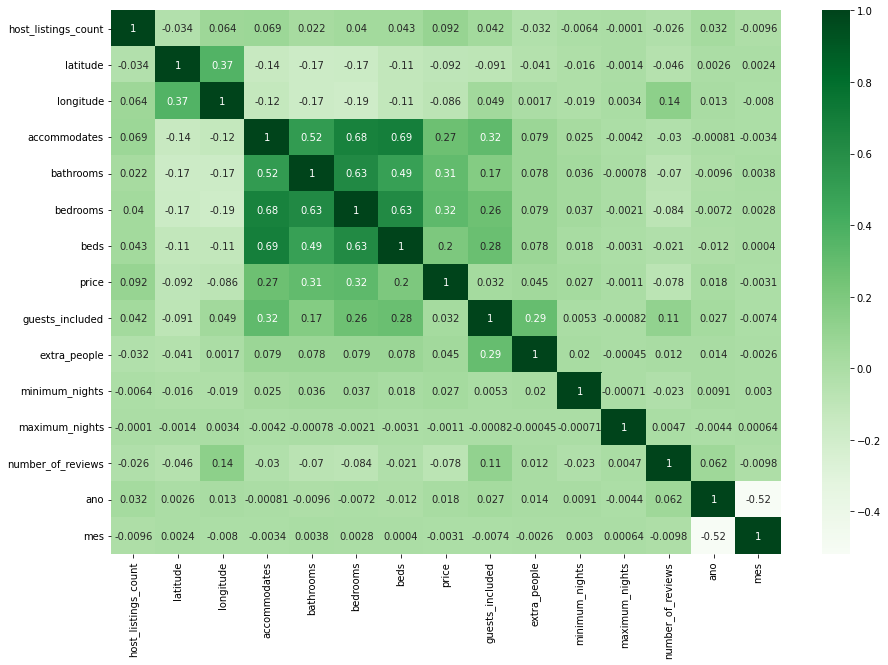

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

__Definição de funções para análise de outliers__

- Vamos definir algumas funções para ajudar na análise de outliers das colunas.

In [22]:
def limites(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1
  return q1 - 1.5*amplitude, q3 + 1.5*amplitude

In [23]:
print(limites(base_airbnb['price']))
base_airbnb['price'].describe()

(-524.0, 1276.0)


count    897709.000000
mean        648.057922
std        1705.063599
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64

In [24]:
def diagrama_caixa(coluna):
  fig, (ax1,ax2) = plt.subplots(1,2)
  fig.set_size_inches(15,5)
  sns.boxplot(x=coluna, ax=ax1)
  ax2.set_xlim(limites(coluna))
  sns.boxplot(x=coluna, ax=ax2)

In [25]:
def histograma(coluna):
  plt.figure(figsize=(15,5))
  sns.distplot(coluna, hist=True)

In [26]:
def grafico_barras(coluna):
  plt.figure(figsize=(15,5))
  ax = sns.barplot(x = coluna.value_counts().index, y=coluna.value_counts())
  ax.set_xlim(limites(coluna))

In [27]:
def excluir_outliers(coluna, df):
  quantidade_linhas = df.shape[0]
  limite_inferior, limite_superior = limites(df[coluna])
  df = df.loc[(df[coluna] >= limite_inferior) & (df[coluna]<= limite_superior),:]
  linhas_removidas = quantidade_linhas - df.shape[0]
  return df, linhas_removidas


Coluna Price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


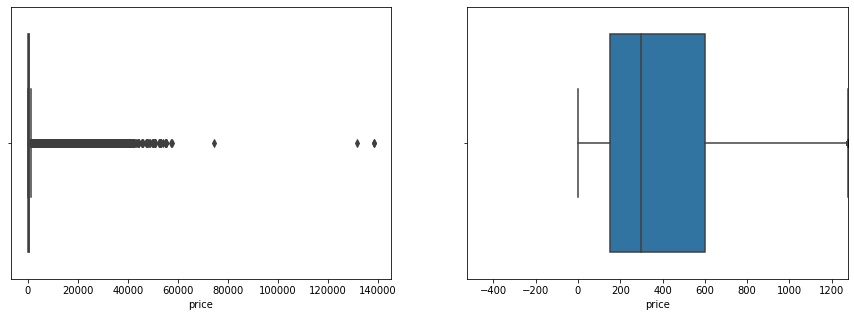

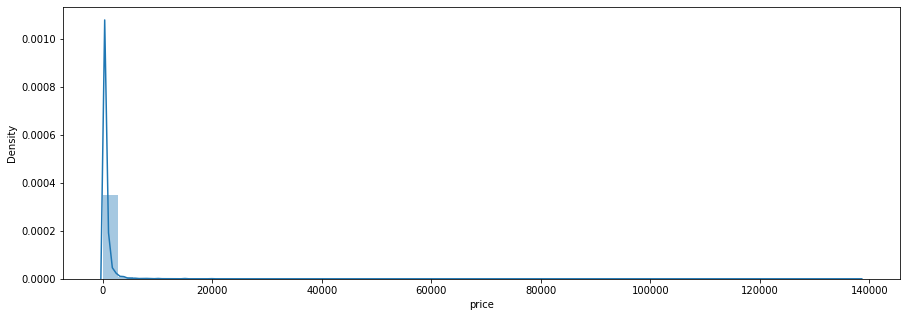

In [28]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior(R$ 1.276) serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(coluna='price', df= base_airbnb)
print(f'Foram removidas um total de {linhas_removidas} linhas')

Foram removidas um total de 87282 linhas


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 24)


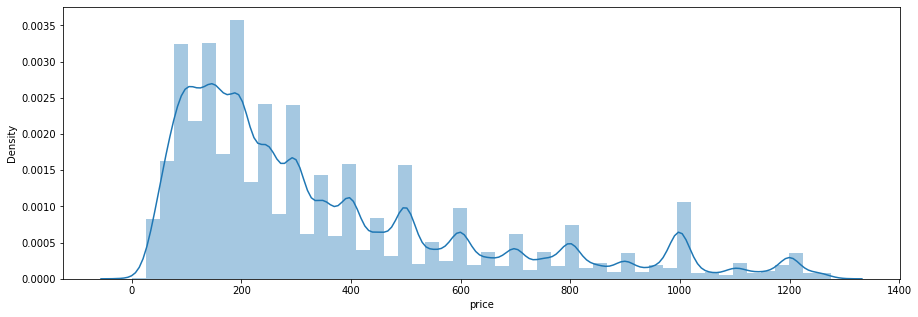

In [30]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

Analisando a Coluna Extra People

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


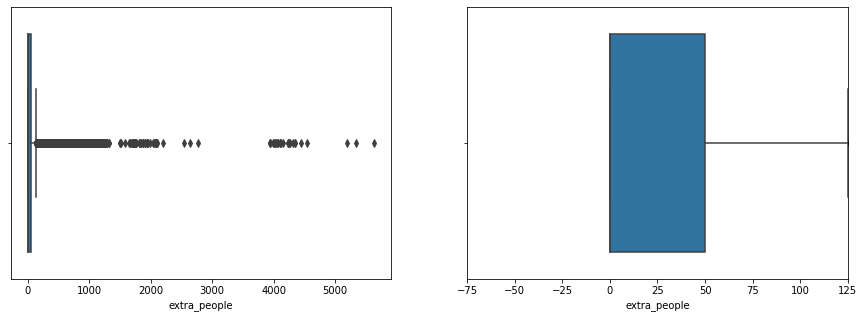

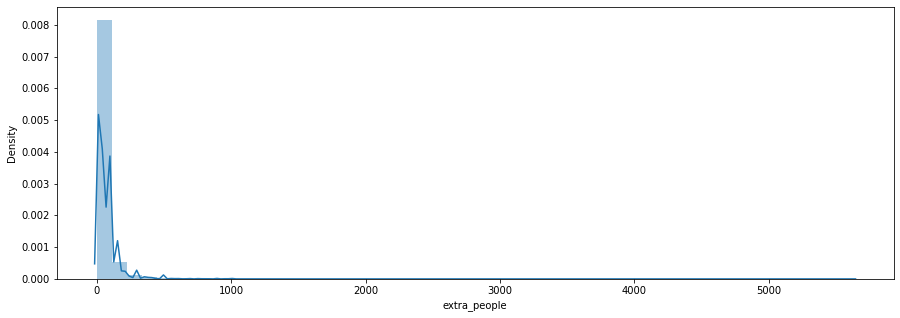

In [31]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [32]:
base_airbnb, linhas_removidas= excluir_outliers(coluna='extra_people', df=base_airbnb)
print(f"Foram removidas um total de {linhas_removidas} linhas")


Foram removidas um total de 59194 linhas


In [33]:
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
host_identity_verified       object
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


# Analisando as variaveis discretas
- host_listings_count         float64
- accommodates                  int64
- bathrooms                   float64
- bedrooms                    float64
- beds                        float64
- guests_included               int64
- minimum_nights                int64
- maximum_nights                int64
- number_of_reviews             int64




Coluna host_listings_count

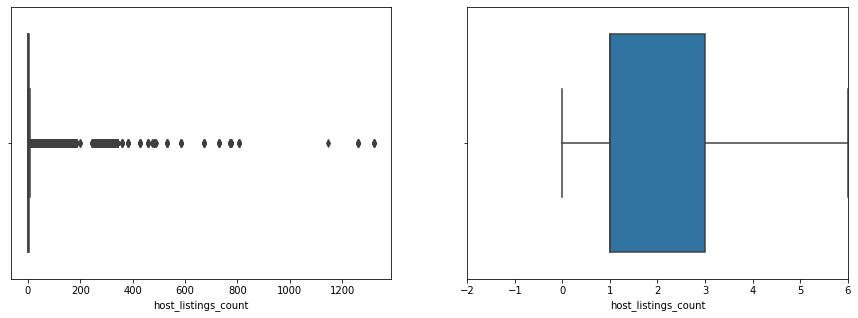

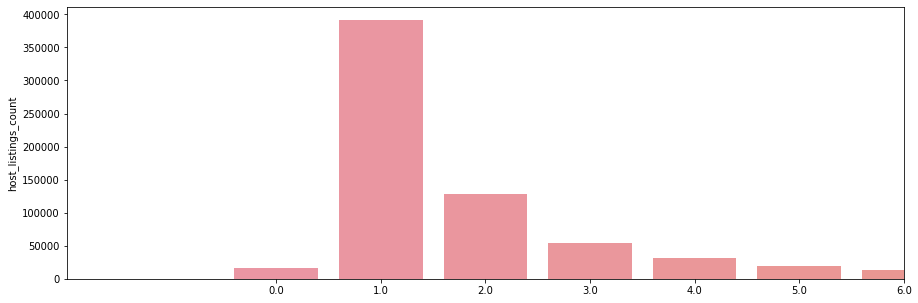

In [34]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barras(base_airbnb['host_listings_count'])

podemos excluir os outiliers, pois o objetivo do nosso projeto é para hosts com até 6 imóveis no airbnb. Visto que por uma análise breve, um proprietário com mais de 6 imóveis provavelmente deixará a gestão dos seus imóveis nas mãos de uma imobiliária ou algo do tipo.

In [35]:
base_airbnb, linhas_removidas = excluir_outliers(coluna='host_listings_count', df=base_airbnb)
print(f'{linhas_removidas} linhas removidas')

97723 linhas removidas


Coluna Accommadates

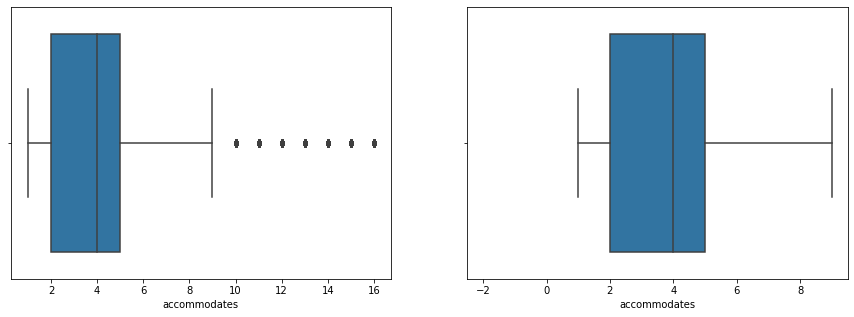

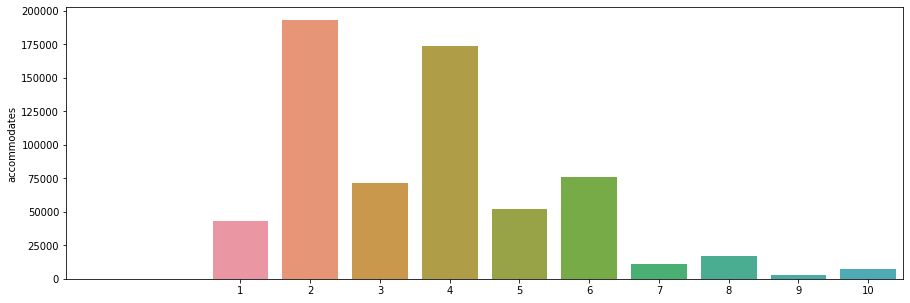

In [36]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barras(base_airbnb['accommodates'])

Excluindo os outiliers com mais de 10 accommodates, pois são valores menores na nossa base de dados

In [37]:
base_airbnb, linhas_removidas = excluir_outliers(coluna='accommodates', df=base_airbnb)
print(f'{linhas_removidas} linhas removidas')

13146 linhas removidas


Coluna Bathrooms

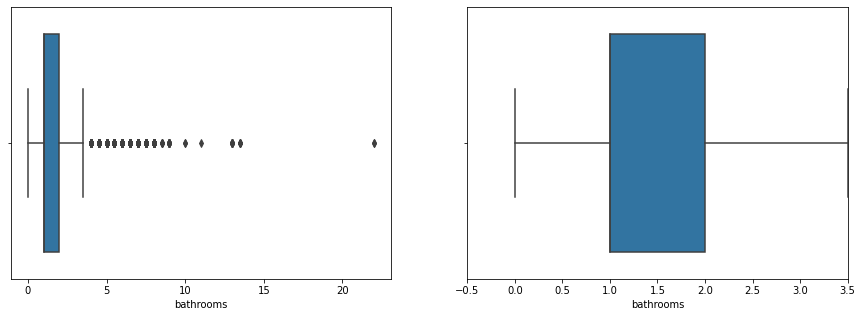

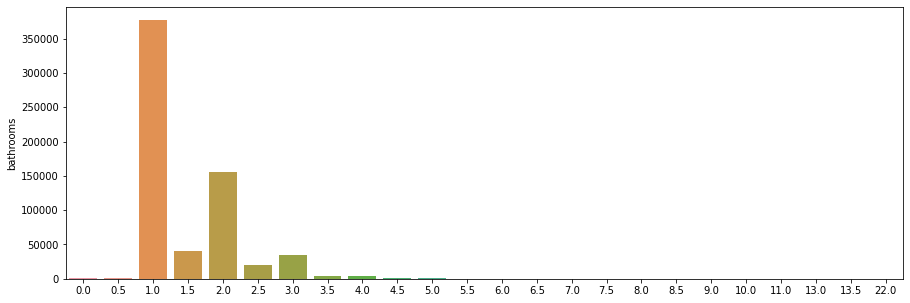

In [38]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x = base_airbnb['bathrooms'].value_counts().index , y=base_airbnb['bathrooms'].value_counts())

In [39]:
base_airbnb, linhas_removidas = excluir_outliers(coluna='bathrooms', df=base_airbnb)
print(f'{linhas_removidas} linhas removidas')

6894 linhas removidas


Analisando Bedrooms

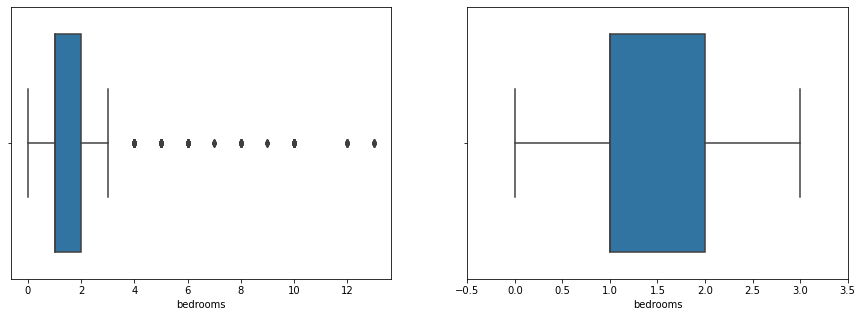

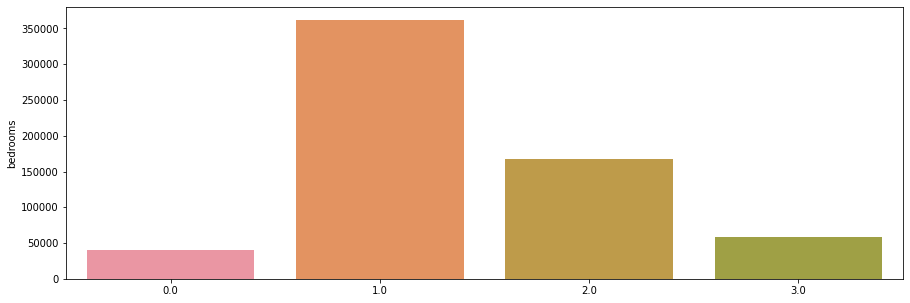

In [40]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barras(base_airbnb['bedrooms'])

In [41]:
base_airbnb, linhas_removidas = excluir_outliers(coluna='bedrooms', df=base_airbnb)
print(f'{linhas_removidas} linhas removidas')

5482 linhas removidas


Analisando a Coluna Beds

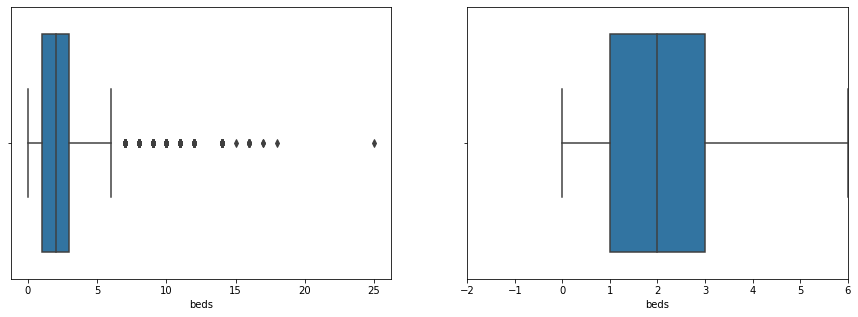

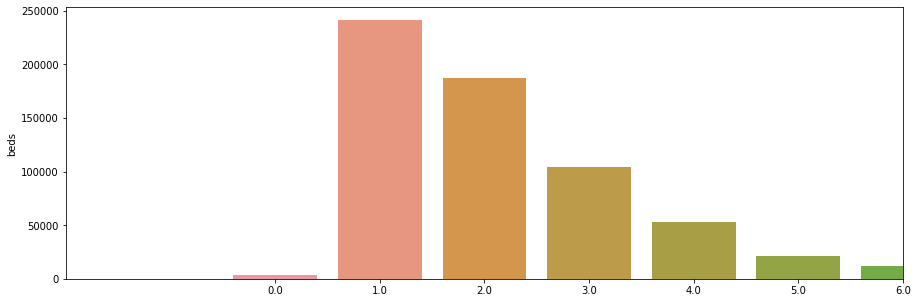

In [42]:
diagrama_caixa(base_airbnb['beds'])
grafico_barras(base_airbnb['beds'])

In [43]:
base_airbnb, linhas_removidas = excluir_outliers(coluna='beds', df=base_airbnb)
print(f'{linhas_removidas} linhas removidas')

5622 linhas removidas


Analisando a coluna guests_included

(1.0, 1.0)


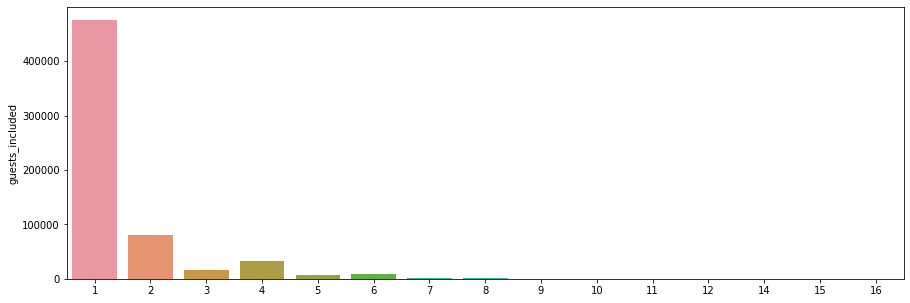

In [44]:
#diagrama_caixa(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15,5))
sns.barplot(x = base_airbnb['guests_included'].value_counts().index , y=base_airbnb['guests_included'].value_counts())

Vamos remover esta feature desta análise, pois parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Iosso pode interferir no nosso modelo ao considerar isso como uma feature que na verdade não é essencial para a definição do preço. Por isso, me parece melhor excluir a coluna da nossa análise.

In [45]:
 base_airbnb = base_airbnb.drop('guests_included', axis=1)

In [46]:
print(base_airbnb.shape)

(622366, 23)


Analisando o Minimum_nights

(-3.5, 8.5)


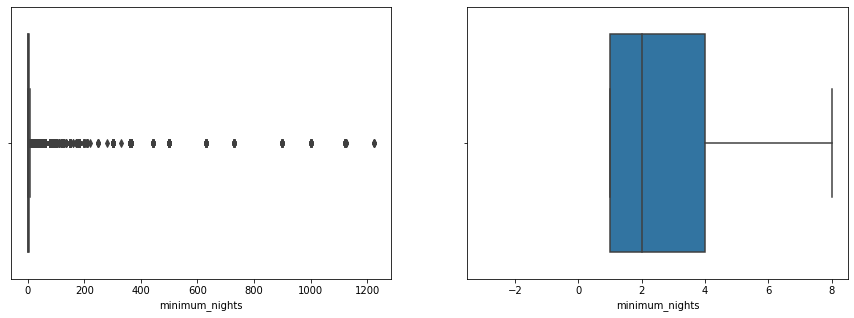

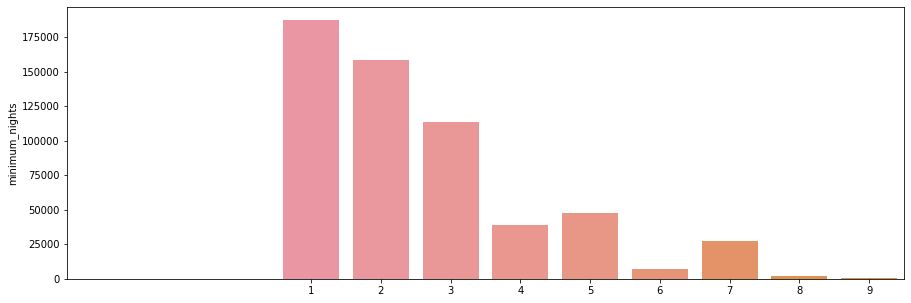

In [47]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barras(base_airbnb['minimum_nights'])
print(limites((base_airbnb['minimum_nights'])))

In [48]:
base_airbnb, linhas_removidas = excluir_outliers(coluna= 'minimum_nights', df=base_airbnb)
print(f'Linhas removidas {linhas_removidas}')

Linhas removidas 40383


Analisando a Coluna Maximum_nights

(-1612.5, 2767.5)


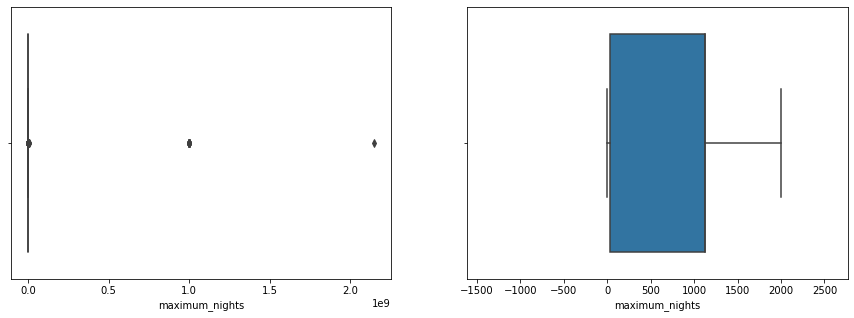

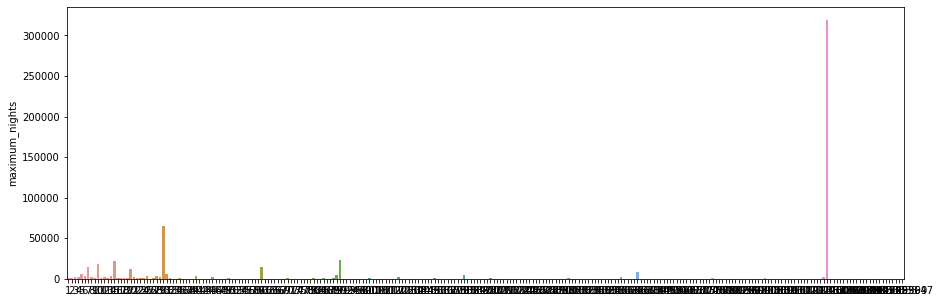

In [49]:
diagrama_caixa(base_airbnb['maximum_nights'])
print(limites(base_airbnb['maximum_nights']))
plt.figure(figsize=(15,5))
sns.barplot(x= base_airbnb['maximum_nights'].value_counts().index, y=base_airbnb['maximum_nights'].value_counts())

Iremos tirar o maximum_nights da análise, pois o objetivo do nosso modelo não é analisar o valor ideal do aluguel para todos os tipos de imóveis, mas sim para aqueles que tem a finalidade de uso para alguns dias ou finais de semana. Então, utilizaremos como métrica de dias apenas os dias mínimos de noites. Pois parece que as pessoas não costumam preencher este campo na hora que criam os anúncios

In [50]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

In [51]:
print(base_airbnb.shape)

(581983, 22)


Analisando Number_of_reviews

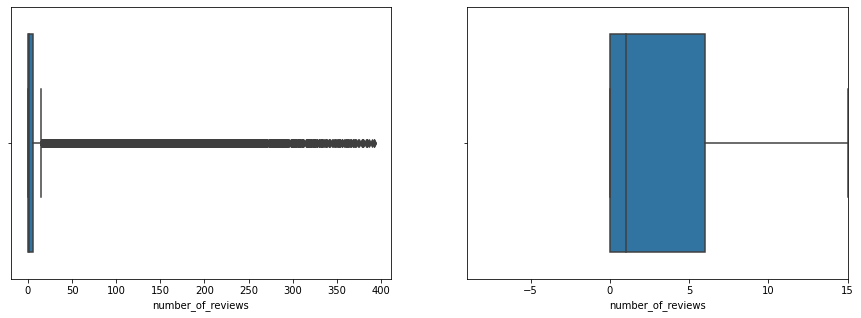

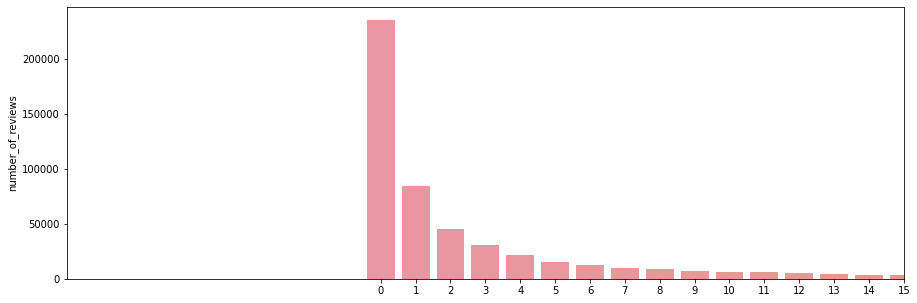

In [52]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barras(base_airbnb['number_of_reviews'])

No caso, o nosso modelo está sendo pensado para qualquer pessoa que queira alugar um imóvel no airbnb, mas que não tem parâmetro nenhum de preço. Então, caso o numero de reviews importar, meio que para uma pessoa que não tem review nenhum o nosso modelo pode inferir para ela um valor abaixo ou maior por simplesmente não ter nenhuma review. Então irei retirar da nossa métrica.

In [53]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
print(base_airbnb.shape)

(581983, 21)


Analisando variáveis categóricas
- host_is_superhost            
- host_identity_verified       
- property_type                
- room_type                    
- bed_type                     
- amenities                    
- instant_bookable             
- is_business_travel_ready     
- cancellation_policy          


Analisando a coluna property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


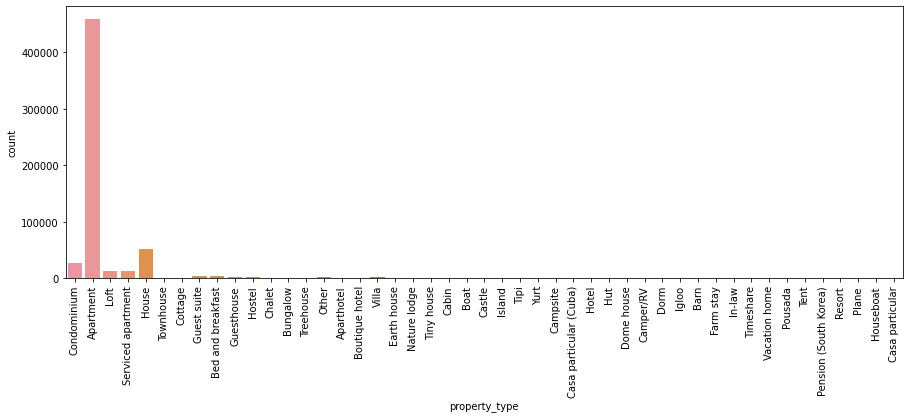

In [54]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

Agrupando os tipos de imóveis inferiores a 2000 em quantidade como Outros. Para facilitar o entendimento para o nosso modelo.

In [55]:
tabela_tipos_imoveis = base_airbnb['property_type'].value_counts()
colunas_agrupar = []
for tipo in tabela_tipos_imoveis.index:
  if tabela_tipos_imoveis[tipo] < 2000:
    colunas_agrupar.append(tipo)
print(colunas_agrupar)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Pousada', 'Timeshare', 'Houseboat', 'Casa particular', 'Plane']


In [56]:
for tipo in colunas_agrupar:
  base_airbnb.loc[base_airbnb['property_type'] ==tipo , 'property_type'] = 'Outros'
print(base_airbnb['property_type'].value_counts())

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


Analisando Room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


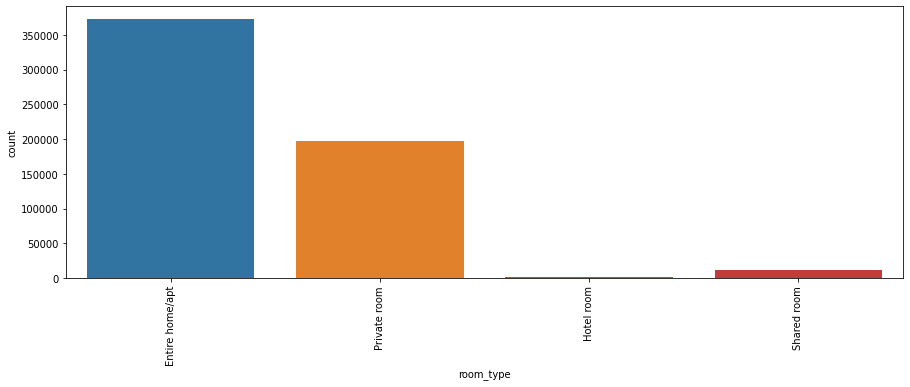

In [57]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

Analisando bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


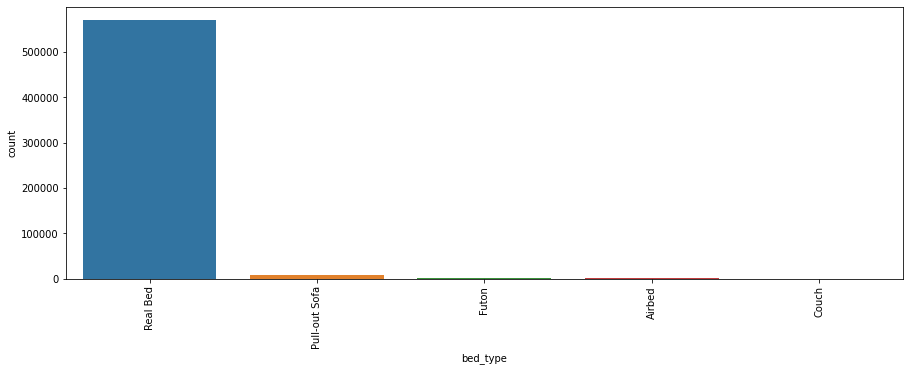

In [58]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

Como temos 4 outras categorias com uma quantidade muito pequena de valores, podemos agrupar em uma única categoria chamada Outros tipos de camas. Assim, nosso modelo irá apaenas analisar de forma mais simples se é uma Real Bed ou não.

In [59]:
tabela_tipos_cama = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []
for tipo in tabela_tipos_cama.index:
  if tabela_tipos_cama[tipo] < 8100:
    colunas_agrupar.append(tipo)
print(colunas_agrupar)

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']


Real Bed                570643
Outros Tipos de Cama     11340
Name: bed_type, dtype: int64


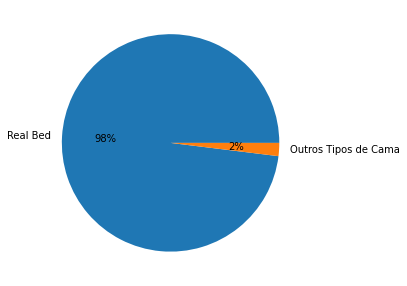

In [60]:
for tipo in colunas_agrupar:
  base_airbnb.loc[base_airbnb['bed_type'] ==tipo , 'bed_type'] = 'Outros Tipos de Cama'
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15,5))
plt.pie(base_airbnb['bed_type'].value_counts(), labels = base_airbnb['bed_type'].value_counts().index,autopct='%.0f%%')
plt.show()

Analisando coluna cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


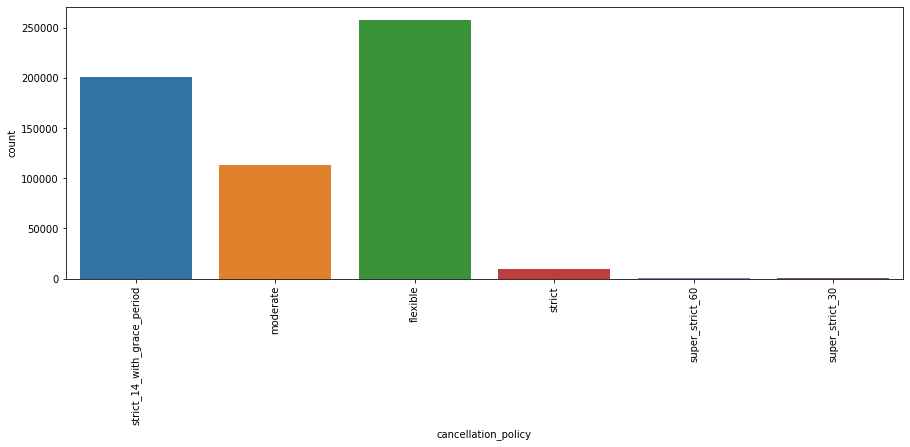

In [61]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

Como as variáveis strict, super_strict_60 e super_strict_30 tem valores muito distintos das outras 3 variáveis. Então, vamos juntar as três variáveis como grupo strict.

In [62]:
tabela_tipos_cancelamento = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []
for tipo in tabela_tipos_cancelamento.index:
  if tabela_tipos_cancelamento[tipo] < 9700:
    colunas_agrupar.append(tipo)
print(colunas_agrupar)

['strict', 'super_strict_60', 'super_strict_30']


In [63]:
for tipo in colunas_agrupar:
  base_airbnb.loc[base_airbnb['cancellation_policy'] ==tipo , 'cancellation_policy'] = 'Strict'
print(base_airbnb['cancellation_policy'].value_counts())

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
Strict                           9863
Name: cancellation_policy, dtype: int64


flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
Strict                           9863
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


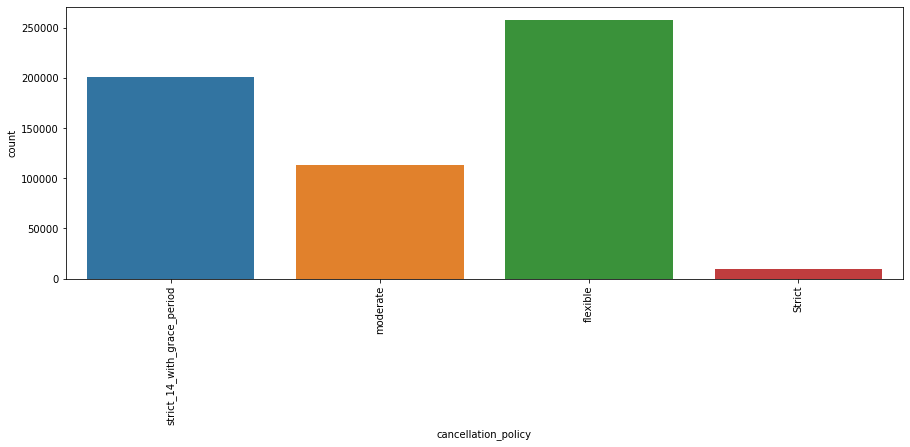

In [64]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

Analisando a coluna amenities
- Iremos fazer a consideração pela quantidade de amenities no imóvel

In [66]:
print(base_airbnb['amenities'].iloc[0].split(","))

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Building staff"', '"Private entrance"', '"Hot water"', '"Bed linens"', 'Microwave', '"Coffee maker"', 'Refrigerator', '"Dishes and silverware"', '"Cooking basics"', 'Oven', 'Stove', '"Patio or balcony"', '"Luggage dropoff allowed"}']


In [67]:
base_airbnb['numero_amenities']= base_airbnb['amenities'].str.split(",").apply(len)

In [71]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 21)

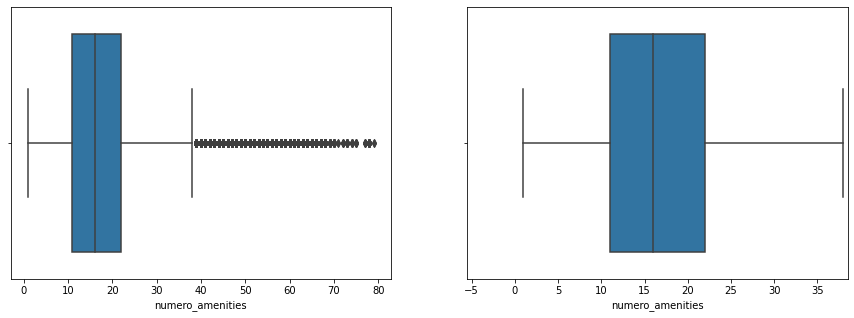

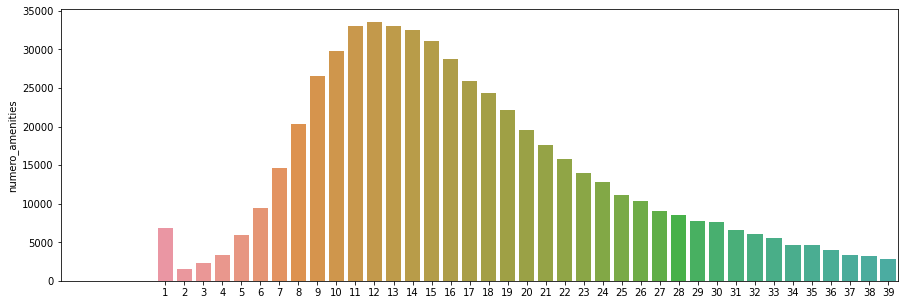

In [72]:
diagrama_caixa(base_airbnb['numero_amenities'])
grafico_barras(base_airbnb['numero_amenities'])

In [73]:
base_airbnb, linhas_removidas = excluir_outliers(coluna= 'numero_amenities', df= base_airbnb)
print(f"foram removidas {linhas_removidas} linhas")

foram removidas 24343 linhas


## Visualização de Mapa das Propriedades

In [76]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}
fig = px.density_mapbox(amostra, lat = 'latitude', lon = 'longitude', z='price', radius = 2.5, center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
fig.show()

# Enconding
- Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true, false e etc.)
  1. Features de Valores True or False, vamos substituir True por 1 e False por 0
  2. Features de Categoria (fetures em que os valores da coluna são textos) vamos utilizar o método de enconding de variáveis dummies

In [83]:
colunas_true_or_false = ['host_is_superhost',"instant_bookable", "is_business_travel_ready", 'host_identity_verified']
base_airbnb_enconding = base_airbnb.copy()
for coluna in colunas_true_or_false:
  base_airbnb_enconding.loc[base_airbnb_enconding[coluna] =='t', coluna] = 1
  base_airbnb_enconding.loc[base_airbnb_enconding[coluna] =='f', coluna] = 0

In [84]:
colunas_categoricas = ['room_type','property_type', 'bed_type','cancellation_policy']
base_airbnb_enconding = pd.get_dummies(data=base_airbnb_enconding, columns=colunas_categoricas)
display(base_airbnb_enconding.head())

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,ano,mes,numero_amenities,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed and breakfast,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Loft,property_type_Outros,property_type_Serviced apartment,bed_type_Outros Tipos de Cama,bed_type_Real Bed,cancellation_policy_Strict,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
0,1,2.0,1,-22.96592,-43.17896,5,1.0,2.0,2.0,329.0,62.0,4,1,0,2019,9,33,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,3.0,1,-22.97712,-43.19045,3,1.0,1.0,2.0,158.0,45.0,7,0,0,2019,9,14,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,1,1.0,1,-22.98302,-43.21427,3,1.0,1.0,2.0,270.0,42.0,2,1,0,2019,9,25,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1.0,1,-22.98816,-43.19359,3,1.5,1.0,2.0,374.0,62.0,2,0,0,2019,9,31,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
16,0,2.0,1,-22.92873,-43.17473,4,2.0,3.0,4.0,258.0,0.0,4,0,0,2019,9,22,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


# Criando o modelo de previsão

In [101]:
def avaliar_modelo(nome_do_modelo, y_teste, previsao):
  r2 = r2_score(y_teste, previsao)
  RSME = np.sqrt(mean_squared_error(y_teste, previsao))
  return f'Modelo {nome_do_modelo}: \n R²: {r2:.2%} \n RSME: {RSME:.2f}'

Escolha dos modelos a serem testados

1. Random Forest
2. Extra Tree
3. Linear Regression



In [95]:
modelos = {'RandomForest': RandomForestRegressor(),
           "LinearRegrssion":LinearRegression(),
           "ExtraTrees":ExtraTreesRegressor()}
y = base_airbnb_enconding['price']
x = base_airbnb_enconding.drop('price', axis =1)

Separando os dados em treino e teste + Treino do Modelo

In [100]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 10)

for nome_modelo, modelo in tqdm(modelos.items()):
  #TREINAR
  modelo.fit(x_train, y_train)
  #Testar
  previsao = modelo.predict(x_test)
  print(avaliar_modelo(nome_modelo, y_test, previsao))
  barra_progresso.update(4)


 33%|███▎      | 1/3 [06:51<13:43, 411.81s/it]

Modelo RandomForest: 
 R²: 0.9721915398647265 
 RSME: 43.96529177485298


 67%|██████▋   | 2/3 [06:53<02:50, 170.72s/it]

Modelo LinearRegrssion: 
 R²: 0.32779673878768556 
 RSME: 216.15824060120443


100%|██████████| 3/3 [12:18<00:00, 246.04s/it]

Modelo ExtraTrees: 
 R²: 0.9753285421343814 
 RSME: 41.411303011226124


Ao analisar os resultados obtidos cheguei a conclusão que o melhor modelo é o Extra Trees, pois obteve um melhor R² e também um menor Erro quadrático médio.
* Já o Modelo Linear Regression foi o que teve pior desempenho.
* Enquanto que o Modelo de Random Forest teve um resultado próximo ao do Extra Trees, porém, a rapidez e métricas do Extra Trees foram superiores.

# Ajustes e Melhorias no Melhor Modelo

,0
bedrooms,0.111831
latitude,0.098468
longitude,0.095889
extra_people,0.086803
numero_amenities,0.084287
accommodates,0.074395
bathrooms,0.068493
room_type_Entire home/apt,0.065716
minimum_nights,0.064760
beds,0.050750


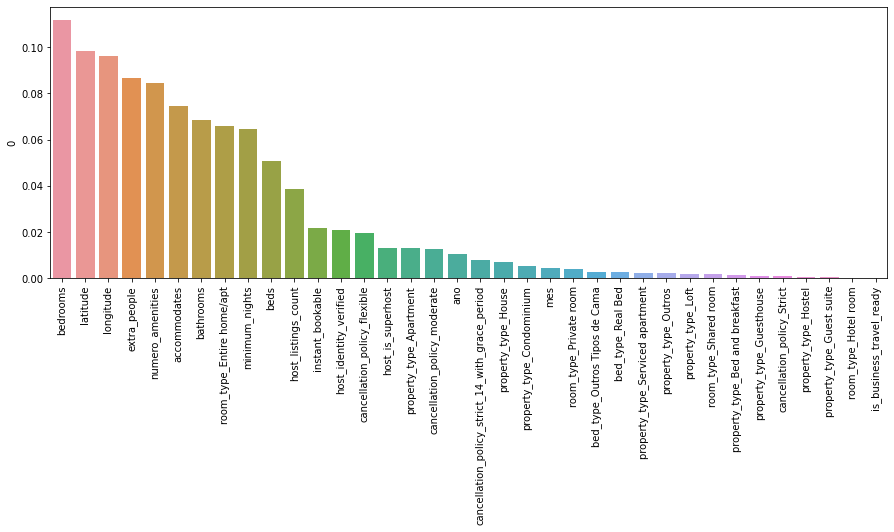

In [112]:
importancia_features = pd.DataFrame(modelos['ExtraTrees'].feature_importances_, index=x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation = 90)

Identificando colunas que tenham um impacto no modelo:
* is_business_travel_ready
* bed_type_Real Bed

In [113]:
base_airbnb_enconding = base_airbnb_enconding.drop('is_business_travel_ready', axis=1)

y = base_airbnb_enconding['price']
x = base_airbnb_enconding.drop('price', axis =1)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)
modelos['ExtraTrees'].fit(X_train, y_train)
previsao = modelos['ExtraTrees'].predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees: 
 R²: 97.54% 
 RSME: 41.38


In [115]:
base_teste = base_airbnb_enconding.copy()
for coluna in base_teste:
  if 'bed_type' in coluna:
    base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
x = base_teste.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)
modelos['ExtraTrees'].fit(X_train, y_train)
previsao = modelos['ExtraTrees'].predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees: 
 R²: 97.54% 
 RSME: 41.35


# Deploy do Projeto
  1. Passo 1 -> Criar arquivo do modelo (joblib)
  2. Passo 2 -> Escolher a forma de deploy:
    * Arquivo Executável + Tkinter
    * Deploy em um microsite (Flask)
    * Deploy apenas para uso direto via Streamlit
  3. Passo 3 -> Outro arquivo python (pode ser formato notbook ou não)
  4. Passo 4 -> Importar Streamlit e criar código
  5. Passo 5 -> Atribuir ao botão o carregamento do modelo
  6. Passo 6 -> Deploy feito

In [116]:
#Salvando o modelo em planilha
x['price'] = y
x.to_csv('dados.csv')

Criação do arquivo em formato joblib

In [117]:
import joblib
joblib.dump(modelos['ExtraTrees'], 'modelo.joblib')

['modelo.joblib']